# Training supervized prediction : Prédire la consommation d’électricité d’une région/entreprise à partir de données historiques.

Guillaume EGU

## Overview 

This project focuses on an Exploratory Data Analysis (EDA) and a baseline predictive modeling task using passenger count data from the Transilien train network (SNCF). <br>
The dataset contains daily records of passenger traffic across different stations, lines, and time slots.
The goal is to reveals clear temporal patterns and understand this dataset the more I can.

## Contents

<ul style="padding-left: 75px;">
  <li>Import Libraries</li>
  <li>Functions</li>
  <li>EDA &amp; Feature Engineering</li>
  <li>Models
    <ul>
      <li>XGBoost</li>
      <li>Linear Trees</li>
      <li>Prophet</li>
      <li>LSTM and Deep LSTM</li>
    </ul>
  </li>
  <li>Visualization</li>
</ul>


<hr>

### Import Libraries

<hr>

In [ ]:
pip install holidays

: 

In [ ]:
pip install xlrd


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import glob
import os
import matplotlib
import matplotlib.pyplot as plt
 
import seaborn as sns
import xgboost as xgb
import numpy as np
import sklearn

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

<hr>

### Functions

<hr>

In [ ]:
sns.set_style("whitegrid")

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Pertange Error given the true and
    predicted values

    Args:
        - y_true: true values
        - y_pred: predicted values

    Returns:
        - mape: MAPE value for the given predicted values
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

<hr>

### Data Load

<hr>

In [ ]:
DATA_PATH = "datasets"  
files = glob.glob(os.path.join(DATA_PATH, "eCO2mix_RTE_Annuel-Definitif_*.csv"))

dfs = []
for file in files:
    print(f"Chargement : {file}")
    df = pd.read_csv(
        file, sep=",", encoding="latin-1",
        low_memory=False,
        na_values=["", " ", "NA", "N/A", "ND", "n/d", "-", "--"]
    )
    df.columns = df.columns.str.strip().str.lower()

    # Construction robuste de la colonne datetime
    df["datetime"] = pd.to_datetime(df["date"].astype(str) + " " + df["heures"].astype(str), errors="coerce")

    # Filtrer les lignes où les minutes sont 15 ou 45
    df = df[~df["datetime"].dt.minute.isin([15, 45])]

    numeric_cols = [
        "consommation", "fioul", "charbon", "gaz", "nucléaire",
        "eolien", "solaire", "hydraulique", "pompage", "bioénergies"
    ]
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    
    # On garde seulement quelques colonnes utiles
    keep = ["datetime", "consommation"] + [c for c in numeric_cols if c in df.columns and c != "consommation"]
    df = df[keep]
    df = df.dropna(subset=["datetime"])

    dfs.append(df)

# Concat + tri + dédoublonnage
data = (
    pd.concat(dfs, ignore_index=True)
      .sort_values("datetime")
      .drop_duplicates(subset="datetime")
      .set_index("datetime")
)

data.info()
data.head()

Chargement : datasets/eCO2mix_RTE_Annuel-Definitif_2023.csv
Chargement : datasets/eCO2mix_RTE_Annuel-Definitif_2014.csv
Chargement : datasets/eCO2mix_RTE_Annuel-Definitif_2021.csv
Chargement : datasets/eCO2mix_RTE_Annuel-Definitif_2015.csv
Chargement : datasets/eCO2mix_RTE_Annuel-Definitif_2012.csv
Chargement : datasets/eCO2mix_RTE_Annuel-Definitif_2020.csv
Chargement : datasets/eCO2mix_RTE_Annuel-Definitif_2018.csv
Chargement : datasets/eCO2mix_RTE_Annuel-Definitif_2019.csv
Chargement : datasets/eCO2mix_RTE_Annuel-Definitif_2022.csv
Chargement : datasets/eCO2mix_RTE_Annuel-Definitif_2016.csv
Chargement : datasets/eCO2mix_RTE_Annuel-Definitif_2013.csv
Chargement : datasets/eCO2mix_RTE_Annuel-Definitif_2017.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 210384 entries, 2012-01-01 00:00:00 to 2023-12-31 23:30:00
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   consommation  210384 non-null  float64
 1 

,consommation,fioul,charbon,gaz,nucléaire,eolien,solaire,hydraulique,pompage,bioénergies
datetime,,,,,,,,,,
2012-01-01 00:00:00,58315.0,492.0,25.0,3816.0,52697.0,3588.0,0.0,7922.0,-1139.0,719.0
2012-01-01 00:30:00,58315.0,492.0,25.0,3816.0,52697.0,3588.0,0.0,7922.0,-1139.0,719.0
2012-01-01 01:00:00,56231.0,492.0,25.0,3834.0,51747.0,3536.0,0.0,7598.0,-1730.0,721.0
2012-01-01 01:30:00,56075.0,491.0,25.0,3832.0,51950.0,3526.0,0.0,7299.0,-2134.0,722.0
2012-01-01 02:00:00,55532.0,492.0,25.0,3839.0,51625.0,3535.0,0.0,7159.0,-2449.0,719.0


<hr>

###  EDA and Feature engineering

In this step, I want to understand the data, prepare it for analyse and understand trends and seasonalities.

<hr>

In [37]:
data.sample(n=7)

,consommation,fioul,charbon,gaz,nucléaire,eolien,solaire,hydraulique,pompage,bioénergies
datetime,,,,,,,,,,
2023-07-28 21:30:00,42629.0,53.0,15.0,2923.0,32729.0,3846.0,28.0,7692.0,-14.0,1214.0
2014-08-31 13:30:00,42100.0,215.0,0.0,576.0,41402.0,1639.0,2993.0,5203.0,-192.0,806.0
2022-04-05 19:00:00,62009.0,86.0,14.0,6721.0,31806.0,7124.0,1586.0,7541.0,-5.0,1131.0
2023-03-06 03:00:00,57267.0,89.0,16.0,7923.0,34013.0,1261.0,0.0,3221.0,-2702.0,1274.0
2015-09-27 21:30:00,44429.0,210.0,0.0,453.0,38895.0,4695.0,0.0,4650.0,-35.0,858.0
2023-09-06 21:30:00,47256.0,69.0,24.0,3636.0,39257.0,2927.0,0.0,6201.0,-15.0,1113.0
2015-04-26 05:00:00,34612.0,219.0,277.0,699.0,36150.0,1034.0,0.0,4945.0,-2073.0,831.0


In [38]:
data.describe()

,consommation,fioul,charbon,gaz,nucléaire,eolien,solaire,hydraulique,pompage,bioénergies
count,210384.000000,210384.000000,210384.000000,210384.000000,210384.000000,210384.000000,210384.000000,210384.000000,210384.000000,210384.000000
mean,53439.353416,258.528990,831.441383,3459.282754,42489.033857,3253.539547,1225.800175,7040.161514,-778.984081,1001.560741
std,11909.168287,277.336439,1096.143253,2465.190471,7917.716611,2900.773512,2035.774944,2788.824339,987.228009,186.389846
min,29124.000000,18.000000,0.000000,234.000000,19164.000000,21.000000,0.000000,1387.000000,-4086.000000,441.000000
25%,44390.000000,89.000000,15.000000,1181.000000,37750.000000,1229.000000,0.000000,4899.000000,-1458.000000,874.000000
50%,51675.000000,159.000000,377.000000,3040.000000,42082.000000,2296.000000,18.000000,6802.000000,-193.000000,1054.000000
75%,61479.000000,337.000000,1335.000000,5089.000000,47566.000000,4296.000000,1807.000000,8911.000000,-21.000000,1138.000000
max,102098.000000,5926.000000,6265.000000,10591.000000,61712.000000,18254.000000,13395.000000,17947.000000,-1.000000,3252.000000


In [39]:
data.shape

(210384, 10)

On the first look,
we can understand there is a difference between consommation and the sum of all others columns. It's because france export his energy to others countries on demands. <br>
On the analyse i will only use datetime and consommation columns but for more data visualisation i could use other columns <br>
Now let's prepare the data>

In [40]:
#Sort values by date
data = data.sort_values("datetime")

data.isna().any()

consommation    False
fioul           False
charbon         False
gaz             False
nucléaire       False
eolien          False
solaire         False
hydraulique     False
pompage         False
bioénergies     False
dtype: bool

No Nan values, we can continue. <br>
I want to add the bank holidays to our data because it could infer on consommation as week ends. <br>
Bank holidays in France (without specific subdivisions bank holidays) taken here : [Python Holidays](https://github.com/dr-prodigy/python-holidays/tree/beta)

In [41]:
from france import France
import pandas as pd

all_holidays = []
years = range(2012, 2024)
subdivisions = [None, "BL", "GES", "GP", "GY", "MF", "MQ", "NC", "PF", "RE", "WF", "YT"]


metropole = France(years=years)
metropole_days = set((pd.to_datetime(date), name) for date, name in metropole.items())

# metropole days
for date, name in metropole_days:
    all_holidays.append({"date": date})

holidays_df = pd.DataFrame(all_holidays).sort_values(["date"]).drop_duplicates(subset=["date"], keep="first").reset_index(drop=True)

holidays_df.head(5)

,date
0,2012-01-01
1,2012-04-09
2,2012-05-01
3,2012-05-08
4,2012-05-17


In [42]:
# Ajouter une colonne is_holiday à data
data = data.copy()
data["is_holiday"] = data.index.normalize().isin(holidays_df["date"].dt.normalize()).astype(int)
data.sample(n=10)

,consommation,fioul,charbon,gaz,nucléaire,eolien,solaire,hydraulique,pompage,bioénergies,is_holiday
datetime,,,,,,,,,,,
2013-01-16 23:00:00,81136.0,462.0,3702.0,6966.0,57337.0,933.0,0.0,10733.0,-10.0,738.0,0
2021-06-24 14:00:00,50739.0,67.0,0.0,2839.0,40027.0,1520.0,5105.0,8553.0,-46.0,1030.0,0
2021-08-09 22:30:00,42279.0,62.0,0.0,652.0,38304.0,1128.0,3.0,8601.0,-70.0,1124.0,0
2017-07-15 13:00:00,46816.0,136.0,702.0,2251.0,38523.0,1246.0,5033.0,4450.0,-1011.0,1204.0,0
2017-06-21 04:30:00,40300.0,131.0,1029.0,3440.0,36444.0,971.0,0.0,4100.0,-2029.0,1068.0,0
2018-10-30 03:00:00,55486.0,509.0,1243.0,4723.0,45918.0,2836.0,0.0,3025.0,-2031.0,1044.0,0
2017-06-15 06:30:00,42338.0,131.0,508.0,2364.0,37766.0,1086.0,39.0,5657.0,-1468.0,1082.0,0
2017-11-03 11:30:00,59841.0,577.0,2102.0,7182.0,39828.0,642.0,2832.0,4316.0,-7.0,1123.0,0
2016-06-13 02:00:00,37791.0,139.0,18.0,599.0,38147.0,2684.0,0.0,8600.0,-2018.0,890.0,0


I am not sure all banks holidays have been well put

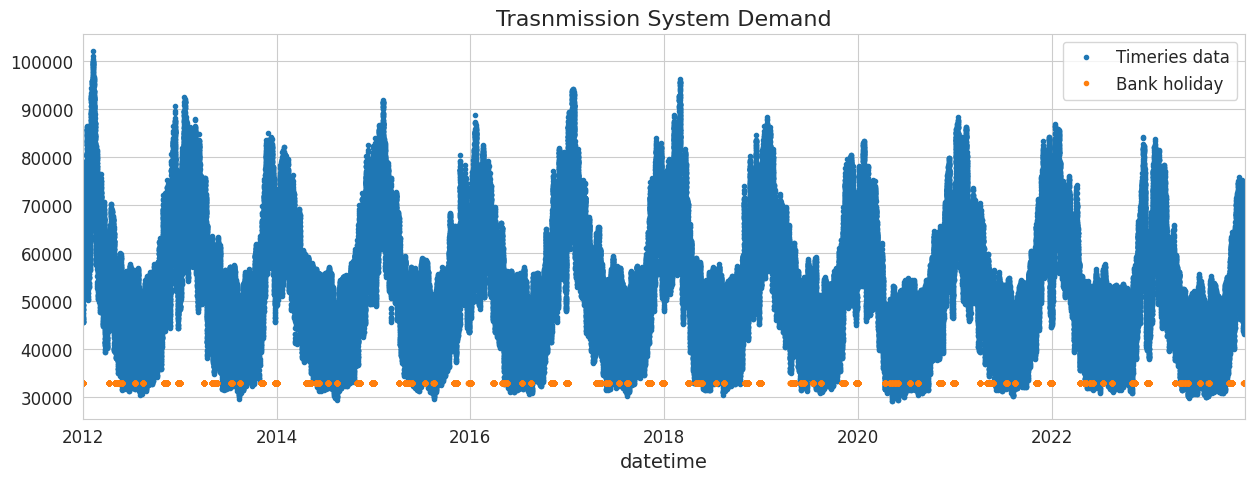

In [43]:
df_plot = data.copy()

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["consommation"].plot(
    style=".", ax=ax, title="Trasnmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

That plot is great to see the behaviour of the time series data. I can see a decreasing trend and a clear yearly seasonality. <br>
Before dealing with outliers, in the above graph we can see a yearly trend, but we cannot focus on daily or weekly patterns. Therefore, let's create a new plot focusing on a single week:

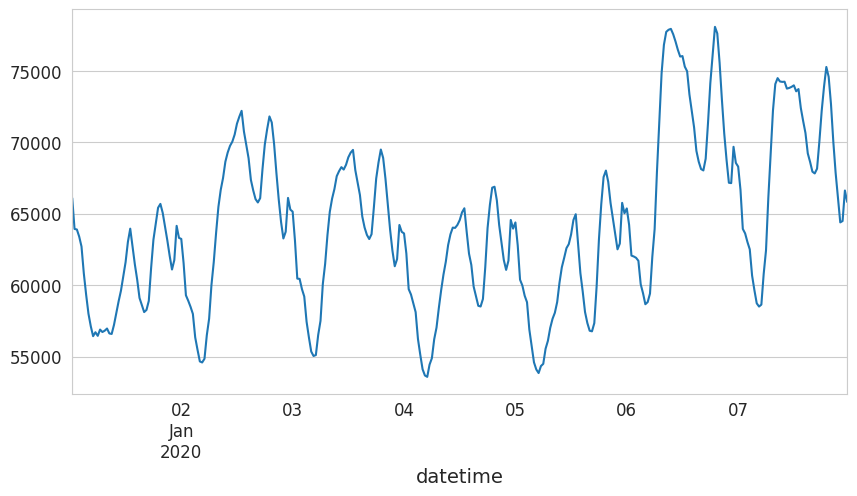

In [44]:
df_plot.loc[(df_plot.index > "01-01-2020") & (df_plot.index < "01-08-2020")][
    "consommation"
].plot(figsize=(10, 5));

It seems our data are valid and good for exploration.
Now I will explore the distribution of electricity demand with respect the different features, such as as hour, month or year. This is a great way to understand the seasonalities in the time series.

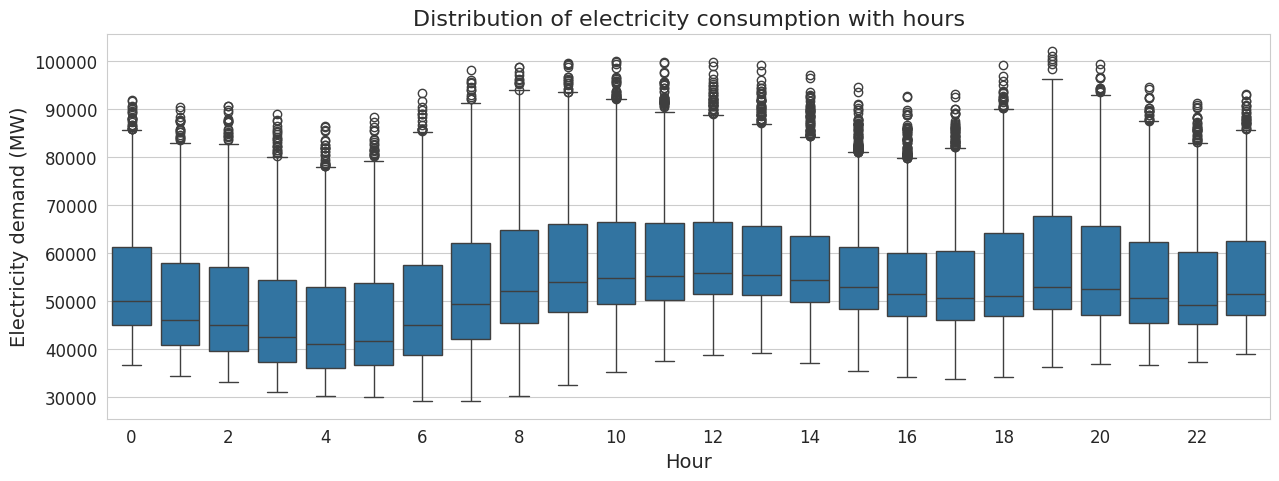

In [45]:
df_plot = data.copy()
df_plot["hour"] = df_plot.index.hour

fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="hour", y="consommation", data=df_plot)

ax.set_xticks(range(0, 24, 2))
ax.set_xticklabels(range(0, 24, 2))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours");

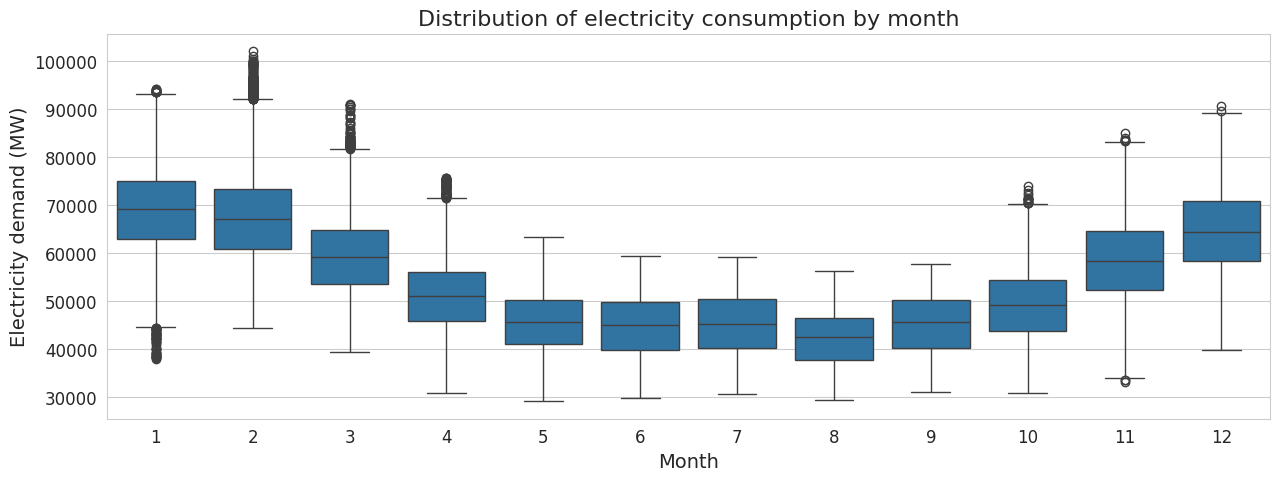

In [46]:
# Boxplot par mois
df_plot = data.copy()
df_plot["month"] = df_plot.index.month
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="consommation", data=df_plot)
ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption by month");

It seems that the lowest consumption occurs during the summer months. It's seems logical as there is not a lot of AC in France and people need to warm up there house thanks to electricity in winter months.
Let's plot on the years, for example 2018, to make sure that I selected the right variable in the above plot.

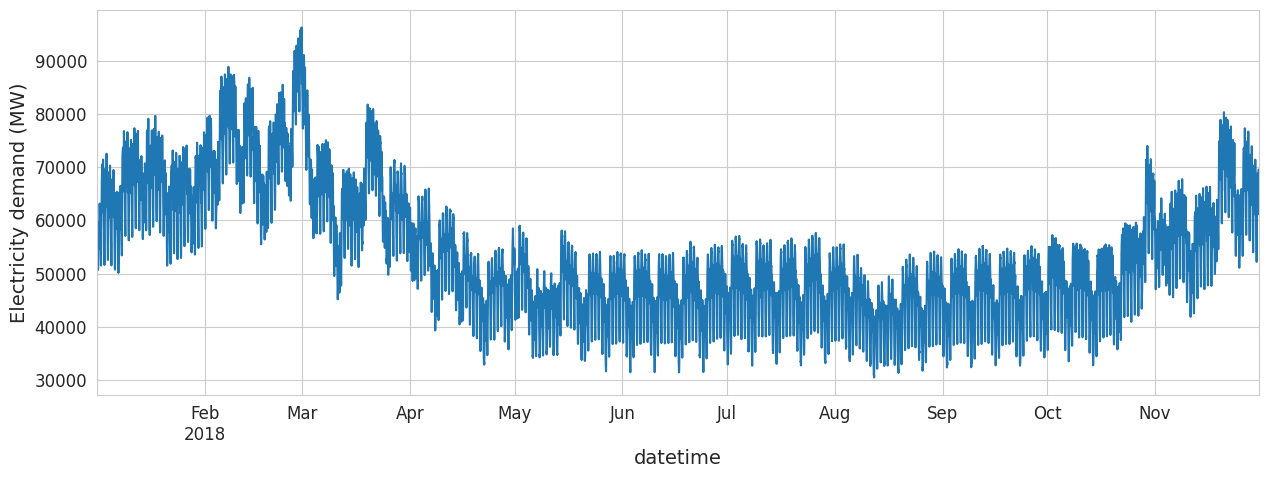

In [47]:
df_plot.loc[(df_plot.index > "01-01-2018") & (df_plot.index < "12-01-2018")]["consommation"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

This plot supports the finding from the previous graph.

Let's look at the effect of bank holidays on electricity consumption:



/tmp/ipykernel_3389/3815876647.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]);


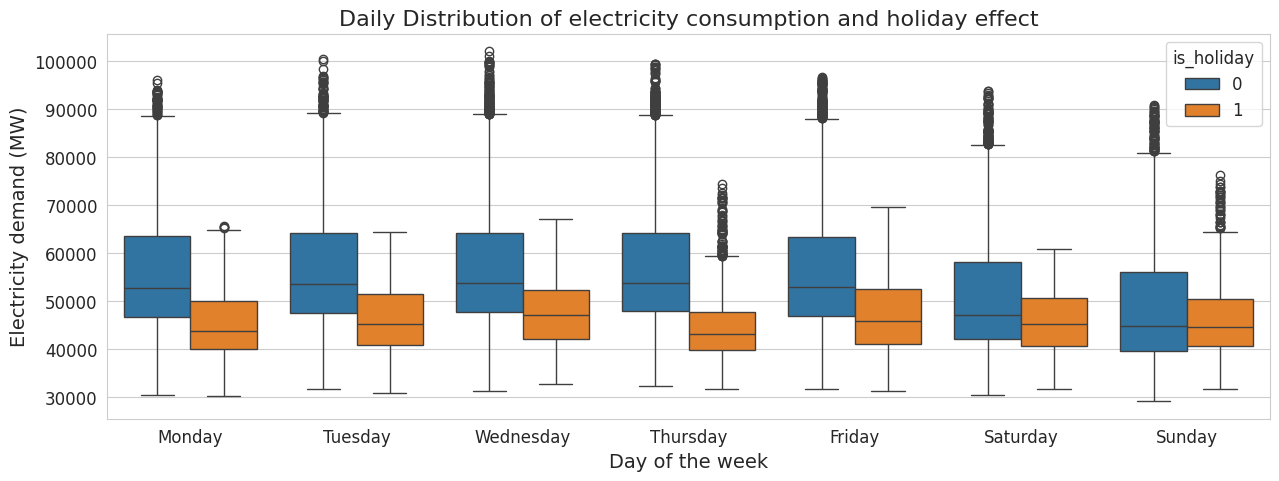

In [48]:
# Boxplot par jour de la semaine et effet jour férié
df_plot = data.copy()
df_plot["day_of_week"] = df_plot.index.dayofweek  # 0=Monday, 6=Sunday
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="consommation", data=df_plot, hue="is_holiday", ax=ax)
ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]);
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Daily Distribution of electricity consumption and holiday effect");

It seems that from Monday to Friday, the electricity consumption is on average lower on bank holidays, whereas it's the same on Saturdays & Sundays.

For non bank holiday, the demand on the weekend is lower than during week days.

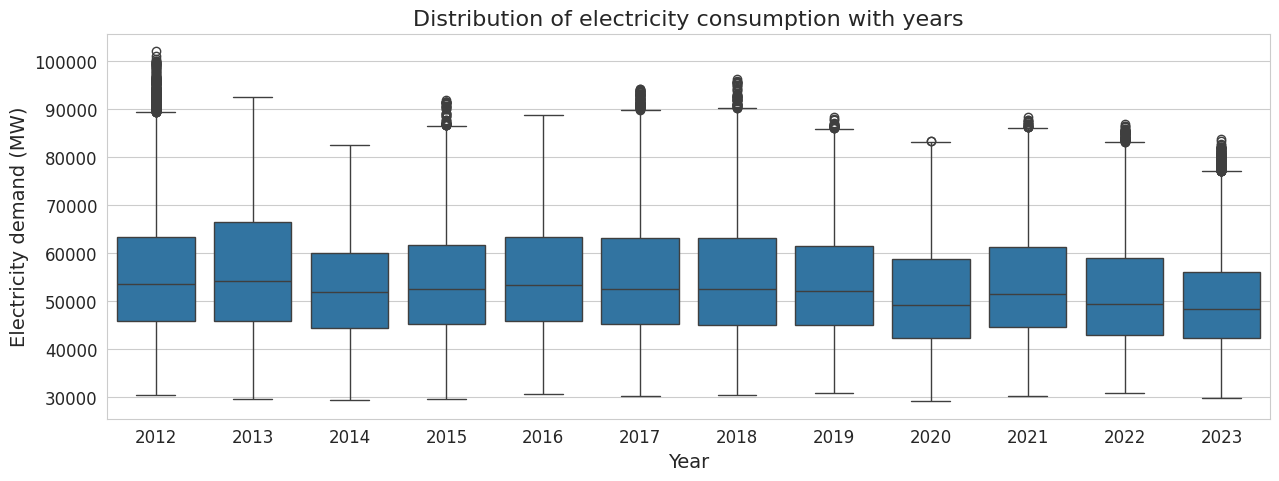

In [49]:
fig, ax = plt.subplots(figsize=(15, 5))
df_plot["year"] = df_plot.index.year
sns.boxplot(x="year", y="consommation", data=df_plot)

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with years");

Although these are yearly average values, one can see a decreasing trend in the electricity consumption. We can overlay the electricity consumption of two years to see how they compare:

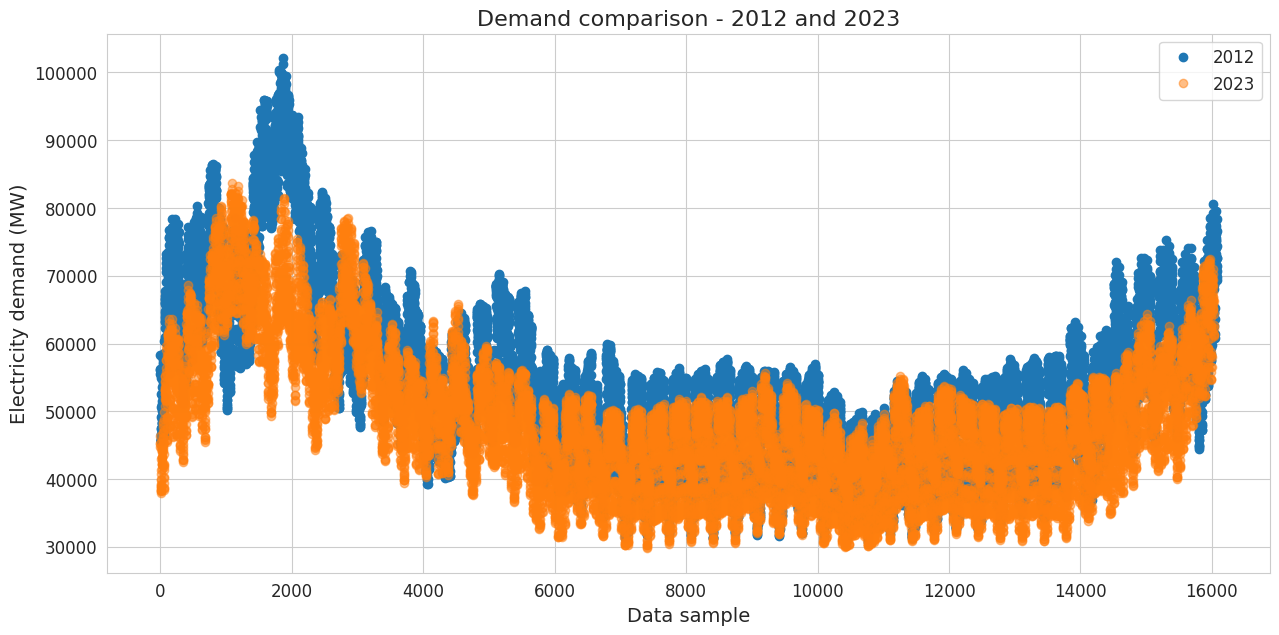

In [50]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(df_plot.loc[(df_plot.index > "01-01-2012") & (df_plot.index < "12-01-2012")]["consommation"])),
    df_plot.loc[(df_plot.index > "01-01-2012") & (df_plot.index < "12-01-2012")]["consommation"],
    "o",
    label="2012",
)

ax.plot(
    range(len(df_plot.loc[(df_plot.index > "01-01-2023") & (df_plot.index < "12-01-2023")]["consommation"])),
    df_plot.loc[(df_plot.index > "01-01-2023") & (df_plot.index < "12-01-2023")]["consommation"],
    "o",
    alpha=0.5,
    label="2023",
)
ax.set_xlabel("Data sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2012 and 2023");

Again, this plot confirms that electricity consumption is decreasing in recent years.

<hr>

### XGBoost


Using XGBoost because it's a regression tool than does a great job with time series data and use multiple features.

Simple XGBoost model

The first XGBoost model is a simple model for which some of the parameters are defined and the data is split into train and test sets. This model is fairly simple, but it's a great baseline.

<hr>

Training - test split
First step is to split the data.


In [51]:
#Define the features and target variable
df = data.copy()
df["settlement_period"] = df.index.hour * 2 + (df.index.minute // 30) + 1
df["day_of_month"] = df.index.day
df["day_of_week"] = df.index.day_of_week
df["day_of_year"] = df.index.day_of_year
df["quarter"] = df.index.quarter
df["month"] = df.index.month
df["year"] = df.index.year
df["week_of_year"] = df.index.isocalendar().week.astype("int64")

#Add three lags to the dataset containing information from the previous 3 years
target_map =df["consommation"].to_dict()

df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)

threshold_date_1 = "2019-01-01"
threshold_date_2 = "2021-01-01"

train_data = df.loc[df.index < threshold_date_1].copy()
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)].copy()
val_data = df.loc[df.index >= threshold_date_2].copy()

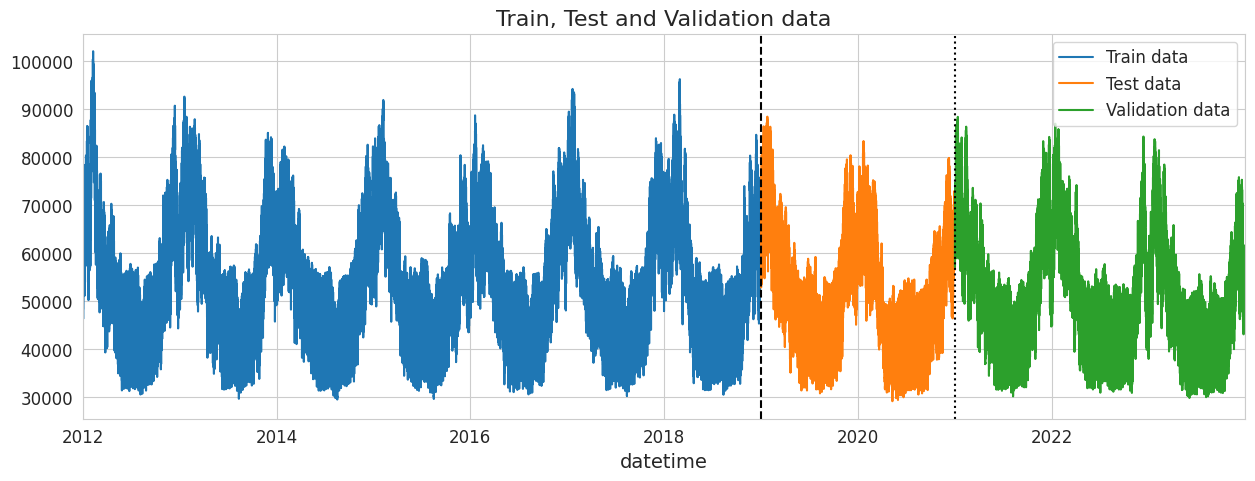

In [52]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["consommation"].plot(ax=ax, label="Train data")
test_data["consommation"].plot(ax=ax, label="Test data")
val_data["consommation"].plot(ax=ax, label="Validation data")
ax.axvline(threshold_date_1, color="k", ls="--")
ax.axvline(threshold_date_2, color="k", ls=":")
ax.set_title("Train, Test and Validation data")
ax.legend();

In [53]:
Features = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
Target = "consommation"

#Prepare the training, testing and validation datasets
X_train = train_data[Features]
y_train = train_data[Target]

X_test = test_data[Features]
y_test = test_data[Target]

X_val = val_data[Features]
y_val = val_data[Target]

#Initialize and train the model
xgb_simple = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    early_stopping_rounds=50,
    random_state=42,
)

xgb_simple.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test), (X_val, y_val)],
    verbose=100,
);
    


[0]	validation_0-rmse:11501.02615	validation_1-rmse:11610.80501


[100]	validation_0-rmse:7024.19686	validation_1-rmse:7392.92606
[200]	validation_0-rmse:5810.19124	validation_1-rmse:6286.64934
[300]	validation_0-rmse:5338.78861	validation_1-rmse:5869.47915
[400]	validation_0-rmse:5138.72245	validation_1-rmse:5684.21845
[499]	validation_0-rmse:5022.95187	validation_1-rmse:5588.83413


<Axes: >

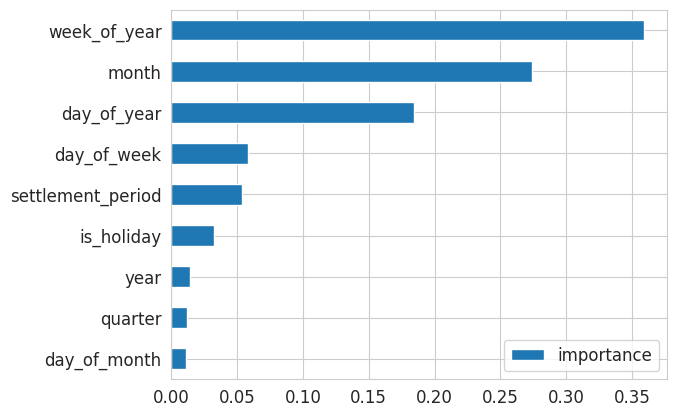

In [54]:
para_importance = pd.DataFrame(
    data= xgb_simple.feature_importances_,
    index= xgb_simple.get_booster().feature_names,
    columns=["importance"]
)

para_importance.sort_values("importance", ascending=True, inplace=True)
para_importance.plot(kind="barh")

In [55]:
result_frame = y_test.to_frame()
result_frame["pred_xgb_simple"] = xgb_simple.predict(X_test)

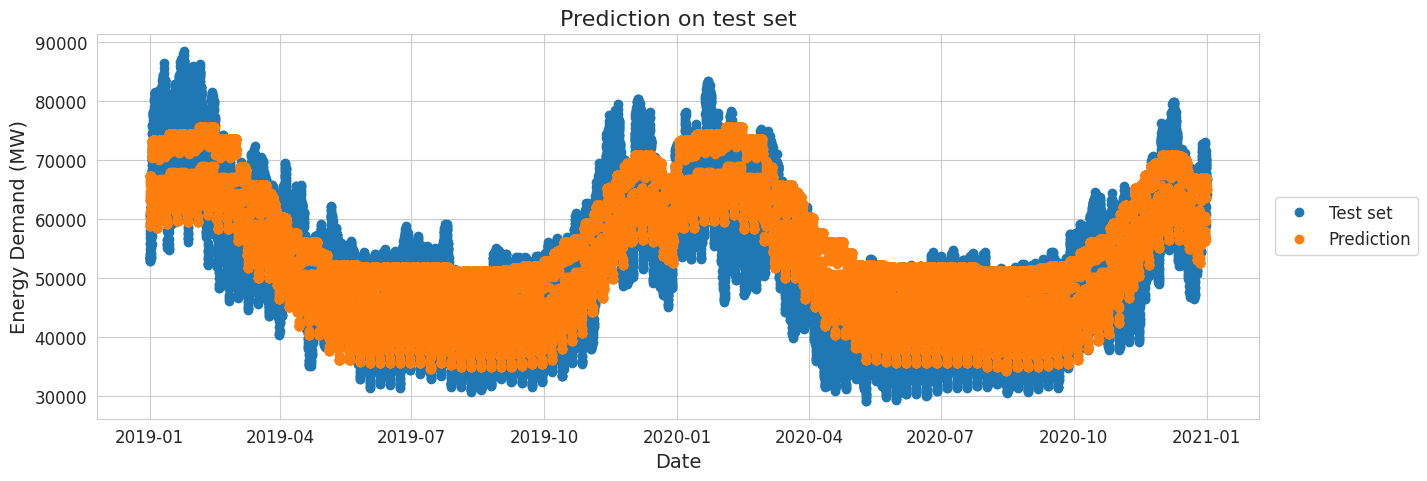

In [56]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["consommation"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_xgb_simple"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

Let's focus on a single week to see how the individual predictions perform compared to the test set

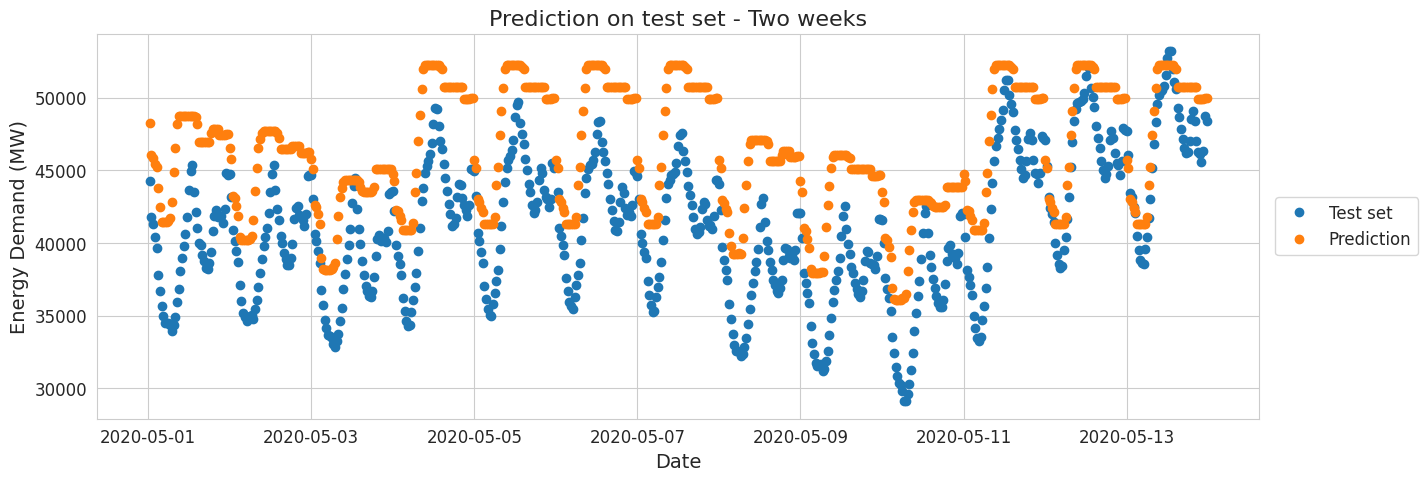

In [57]:
begin = "05-01-2020"
end = "05-14-2020"

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["consommation"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

As can be seen, the model struggles to capture the peaks and valleys. In the next section I will use grid search to see if tuning the model hyperparameters leads to a better prediction.

In [58]:
mape_xgboost_simple = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_simple"]
)

rmse_xgboost_simple = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_simple"]))

print(
    "Mean Absolute Percentage Error of the simple model is: %.2f" % mape_xgboost_simple
)

print(
    "Root Mean Squared Error of the simple models is: %.2f MW" % rmse_xgboost_simple
)

Mean Absolute Percentage Error of the simple model is: 7.98
Root Mean Squared Error of the simple models is: 5022.95 MW


### XGBoost with Cross validation and Grid Search¶
The model above is a good starting point, but it's still underfitted to the data. One can run the model again and change the hyperparameters,but it isn't the right way to train a model if we want to avoid overfitting. This problem can be solved by using cross validation and grid search.

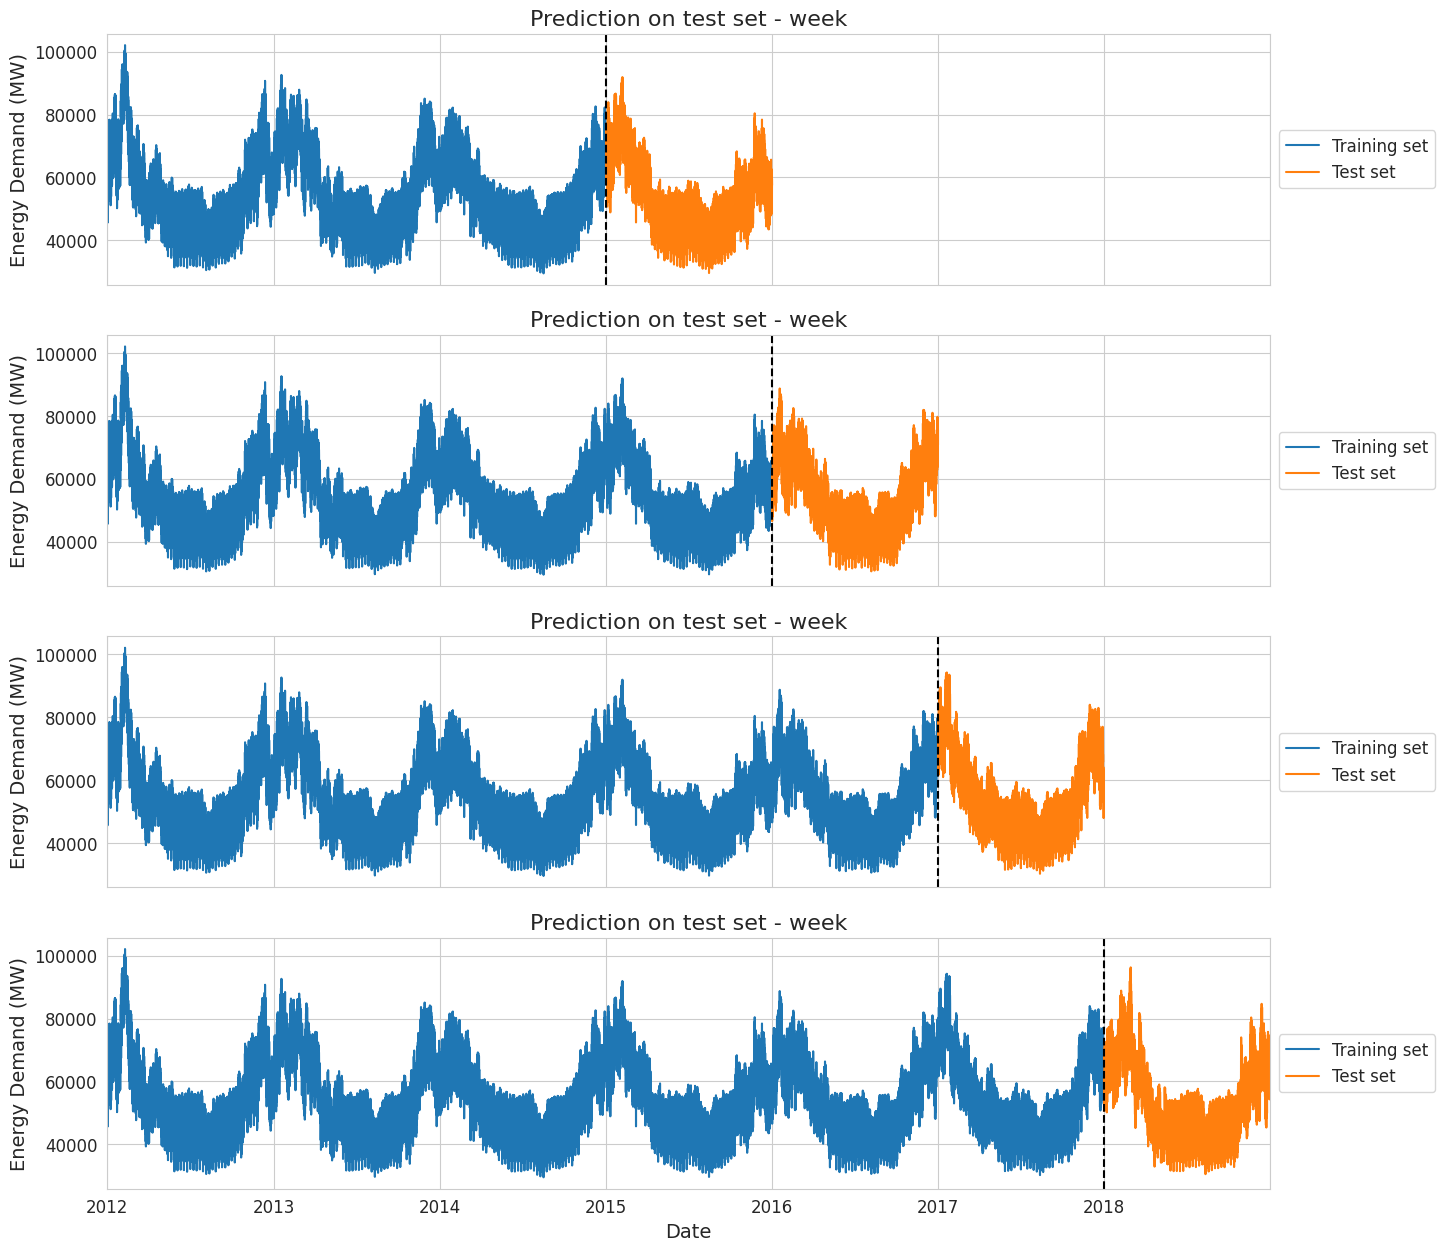

In [59]:
n_years_test = 1
tss = TimeSeriesSplit(n_splits=4, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, test_index in tss.split(df[df.index<threshold_date_1]):

    train = df.iloc[train_index]
    test = df.iloc[test_index]

    train["consommation"].plot(
        ax=axes[fold], label="Training set", title=f"Data Train-test split fold {fold}",
    )
    test["consommation"].plot(ax=axes[fold], label="Test set")
    axes[fold].axvline(test.index.min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date");
    fold += 1

One can combine the cross validation technique for time series, called TimeSeriesSplit with GridSearchCV to find the best parameters for the XGBoost model.

In [60]:
def clean_xy(X, y):
    X = X.copy()
    # cast bool -> int8, forcer numérique sinon NaN
    for c in X.columns:
        if X[c].dtype == bool:
            X[c] = X[c].astype("int8")
        elif X[c].dtype.kind not in "iuif":
            X[c] = pd.to_numeric(X[c], errors="coerce")
    X = X.replace([np.inf, -np.inf], np.nan)
    y = pd.to_numeric(y, errors="coerce")
    y = y.replace([np.inf, -np.inf], np.nan)
    # aligner les index puis dropna de façon jointe
    df = X.join(y.rename("_y_"), how="inner")
    df = df.dropna()
    return df[X.columns], df["_y_"]

X_train_cv, y_train_cv = clean_xy(train_data[FEATURES_CV], train_data[TARGET])
X_val_cv,   y_val_cv   = clean_xy(val_data[FEATURES_CV],   val_data[TARGET])
X_test_cv,  y_test_cv  = clean_xy(test_data[FEATURES_CV],  test_data[TARGET])  # si besoin


NameError: name 'FEATURES_CV' is not defined

In [ ]:
assert X_train_cv.shape[0] == y_train_cv.shape[0]
assert X_val_cv.shape[0]   == y_val_cv.shape[0]
assert X_train_cv.columns.tolist() == X_val_cv.columns.tolist()
assert np.isfinite(X_train_cv.values).all() and np.isfinite(y_train_cv.values).all()
assert np.isfinite(X_val_cv.values).all()   and np.isfinite(y_val_cv.values).all()


In [ ]:
%%time

train_data.index = pd.Index(train_data.index)
test_data.index = pd.Index(test_data.index)

FEATURES_CV = [
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
    "lag1",
    "lag2",
    "lag3",
    "is_holiday",
]
TARGET = "consommation"

# Define train, test and hold-out set for the cv features
X_train_cv = train_data[FEATURES_CV]
y_train_cv = train_data[TARGET]

X_test_cv = test_data[FEATURES_CV]
y_test_cv = test_data[TARGET]

X_val_cv = val_data[FEATURES_CV]
y_val_cv = val_data[TARGET]

# Define fit parameters to allow early stopping in GridSearchCV
fit_params = {
    "eval_set": [(X_val_cv, y_val_cv)],
    "verbose": 500,  
}

# Define estimator
estimator = xgb.XGBRegressor(
    objective="reg:squarederror",
    learning_rate=0.01,
    tree_method="hist",
    device="cpu",          # <- explicite, plus de warning GPU
    random_state=43,
    n_jobs=-1,
            
)

param_search = {
    "max_depth": [3, 5],
    "n_estimators": [350, 500, 650],
    "subsample": [0.95, 0.8, 0.7],
}

xgb_search = GridSearchCV(
    estimator=estimator,
    cv=tss,
    param_grid=param_search,
    scoring="neg_root_mean_squared_error",
    error_score="raise",
    verbose=3,
    return_train_score=True,
)
xgb_search.fit(X_train_cv, y_train_cv)

best_params = xgb_search.best_params_

# Ré-entraîne une seule fois avec early-stopping sur train+val
final_model = xgb.XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    learning_rate=0.01,
    tree_method="hist",
    device="cpu",
    random_state=43,
    n_jobs=-1,
    early_stopping_rounds=50,
    eval_metric="rmse",
)

final_model.fit(
    pd.concat([X_train_cv, X_val_cv]),
    pd.concat([y_train_cv, y_val_cv]),
    eval_set=[(X_val_cv, y_val_cv)],
    verbose=False,
)


Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=(train=-4528.960, test=-4325.795) total time=   2.0s
[CV 2/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=(train=-4451.972, test=-4638.564) total time=   1.5s
[CV 3/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=(train=-4525.440, test=-5154.130) total time=   2.0s
[CV 4/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=(train=-4645.542, test=-4839.932) total time=   1.2s
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=(train=-4521.824, test=-4285.809) total time=   1.5s
[CV 2/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=(train=-4457.666, test=-4638.804) total time=   0.9s
[CV 3/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=(train=-4524.773, test=-5159.895) total time=   3.0s
[CV 4/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=(train=-4634.843, test=-4849.641) to

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,'cpu'
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,'rmse'


In [ ]:
xgb_search.best_params_

{'max_depth': 3, 'n_estimators': 650, 'subsample': 0.8}

In [ ]:
result_frame["pred_xgb_cv_gs"] = xgb_search.predict(X_test_cv)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["consommation"], "o", label="Test data")
ax.plot(
    result_frame.index,
    result_frame["pred_xgb_cv_gs"],
    "o",
    label="Prediction",
    alpha=0.5,
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

NameError: name 'xgb_search' is not defined

In [ ]:
begin = "07-01-2020"
end = "07-14-2020"

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["consommation"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction simple",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_cv_gs"
    ],
    "o",
    label="Prediction cv gs",
)

ax.legend(loc="center", bbox_to_anchor=(1.1, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

NameError: name 'plt' is not defined